In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [38]:
plt.rcParams.update(
    {
        "axes.grid": True,
        "grid.alpha": 0.5,
        "grid.linestyle": "--"
    }
)


## Import data

In [39]:
df = pd.read_csv("../data/FS_features_ABIDE_males.csv", sep=";")
df = df.set_index("FILE_ID")

# drop target
y = df["AGE_AT_SCAN"]
df = df.drop("AGE_AT_SCAN", axis=1)

Number of istances:  915
Number of columns:  422


In [40]:
df.head()

,SEX,FIQ,DX_GROUP,lh_caudalanteriorcingulate_SurfArea,lh_caudalanteriorcingulate_GrayVol,lh_caudalanteriorcingulate_ThickAvg,lh_caudalanteriorcingulate_ThickStd,lh_caudalanteriorcingulate_MeanCurv,lh_caudalanteriorcingulate_CurvInd,lh_caudalmiddlefrontal_SurfArea,...,CC_Mid_Anterior_Volume_mm3,CC_Anterior_Volume_mm3,lh_MeanThickness,rh_MeanThickness,VentricleChoroidVol,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,TotalGrayVol
FILE_ID,,,,,,,,,,,,,,,,,,,,,
Caltech_0051456,1,126.0,1,909,2684,2.918,0.481,0.134,1.3,2655,...,788.7,929.8,2.52039,2.52379,42065,258703.4443,262670.1207,262254.9768,265741.1295,701211.5651
Caltech_0051457,1,107.0,1,1425,4623,3.046,0.543,0.116,2.0,3631,...,907.3,1066.6,2.55533,2.56998,28505,321132.1284,317004.7945,304528.2513,301555.0187,841485.9229
Caltech_0051458,1,93.0,1,1205,3940,2.987,0.423,0.104,1.4,2685,...,964.2,1104.3,2.64518,2.63160,13383,266418.9917,266456.1701,271683.1723,266494.7088,726728.1619
Caltech_0051459,1,106.0,1,1413,4711,2.879,0.587,0.120,1.7,3203,...,811.0,1056.7,2.70814,2.72762,6849,307157.4469,310540.0389,258618.7918,255480.2694,794676.4859
Caltech_0051461,1,99.0,1,875,2270,2.473,0.475,0.104,0.7,2453,...,844.8,1015.4,2.59002,2.61012,73159,263932.5269,269417.2519,242330.5838,232809.9268,714122.7788


## Normalization

In [218]:
np.log(1.2)

0.1823215567939546

In [224]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
def notransform(x):
    return x

scaler = StandardScaler()
same = FunctionTransformer(notransform)

In [225]:
high_variance_col = df.kurtosis().sort_values(ascending=False).head(20).index


/Users/spinap/Library/Caches/pypoetry/virtualenvs/neuroimage-q89akeZ7-py3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


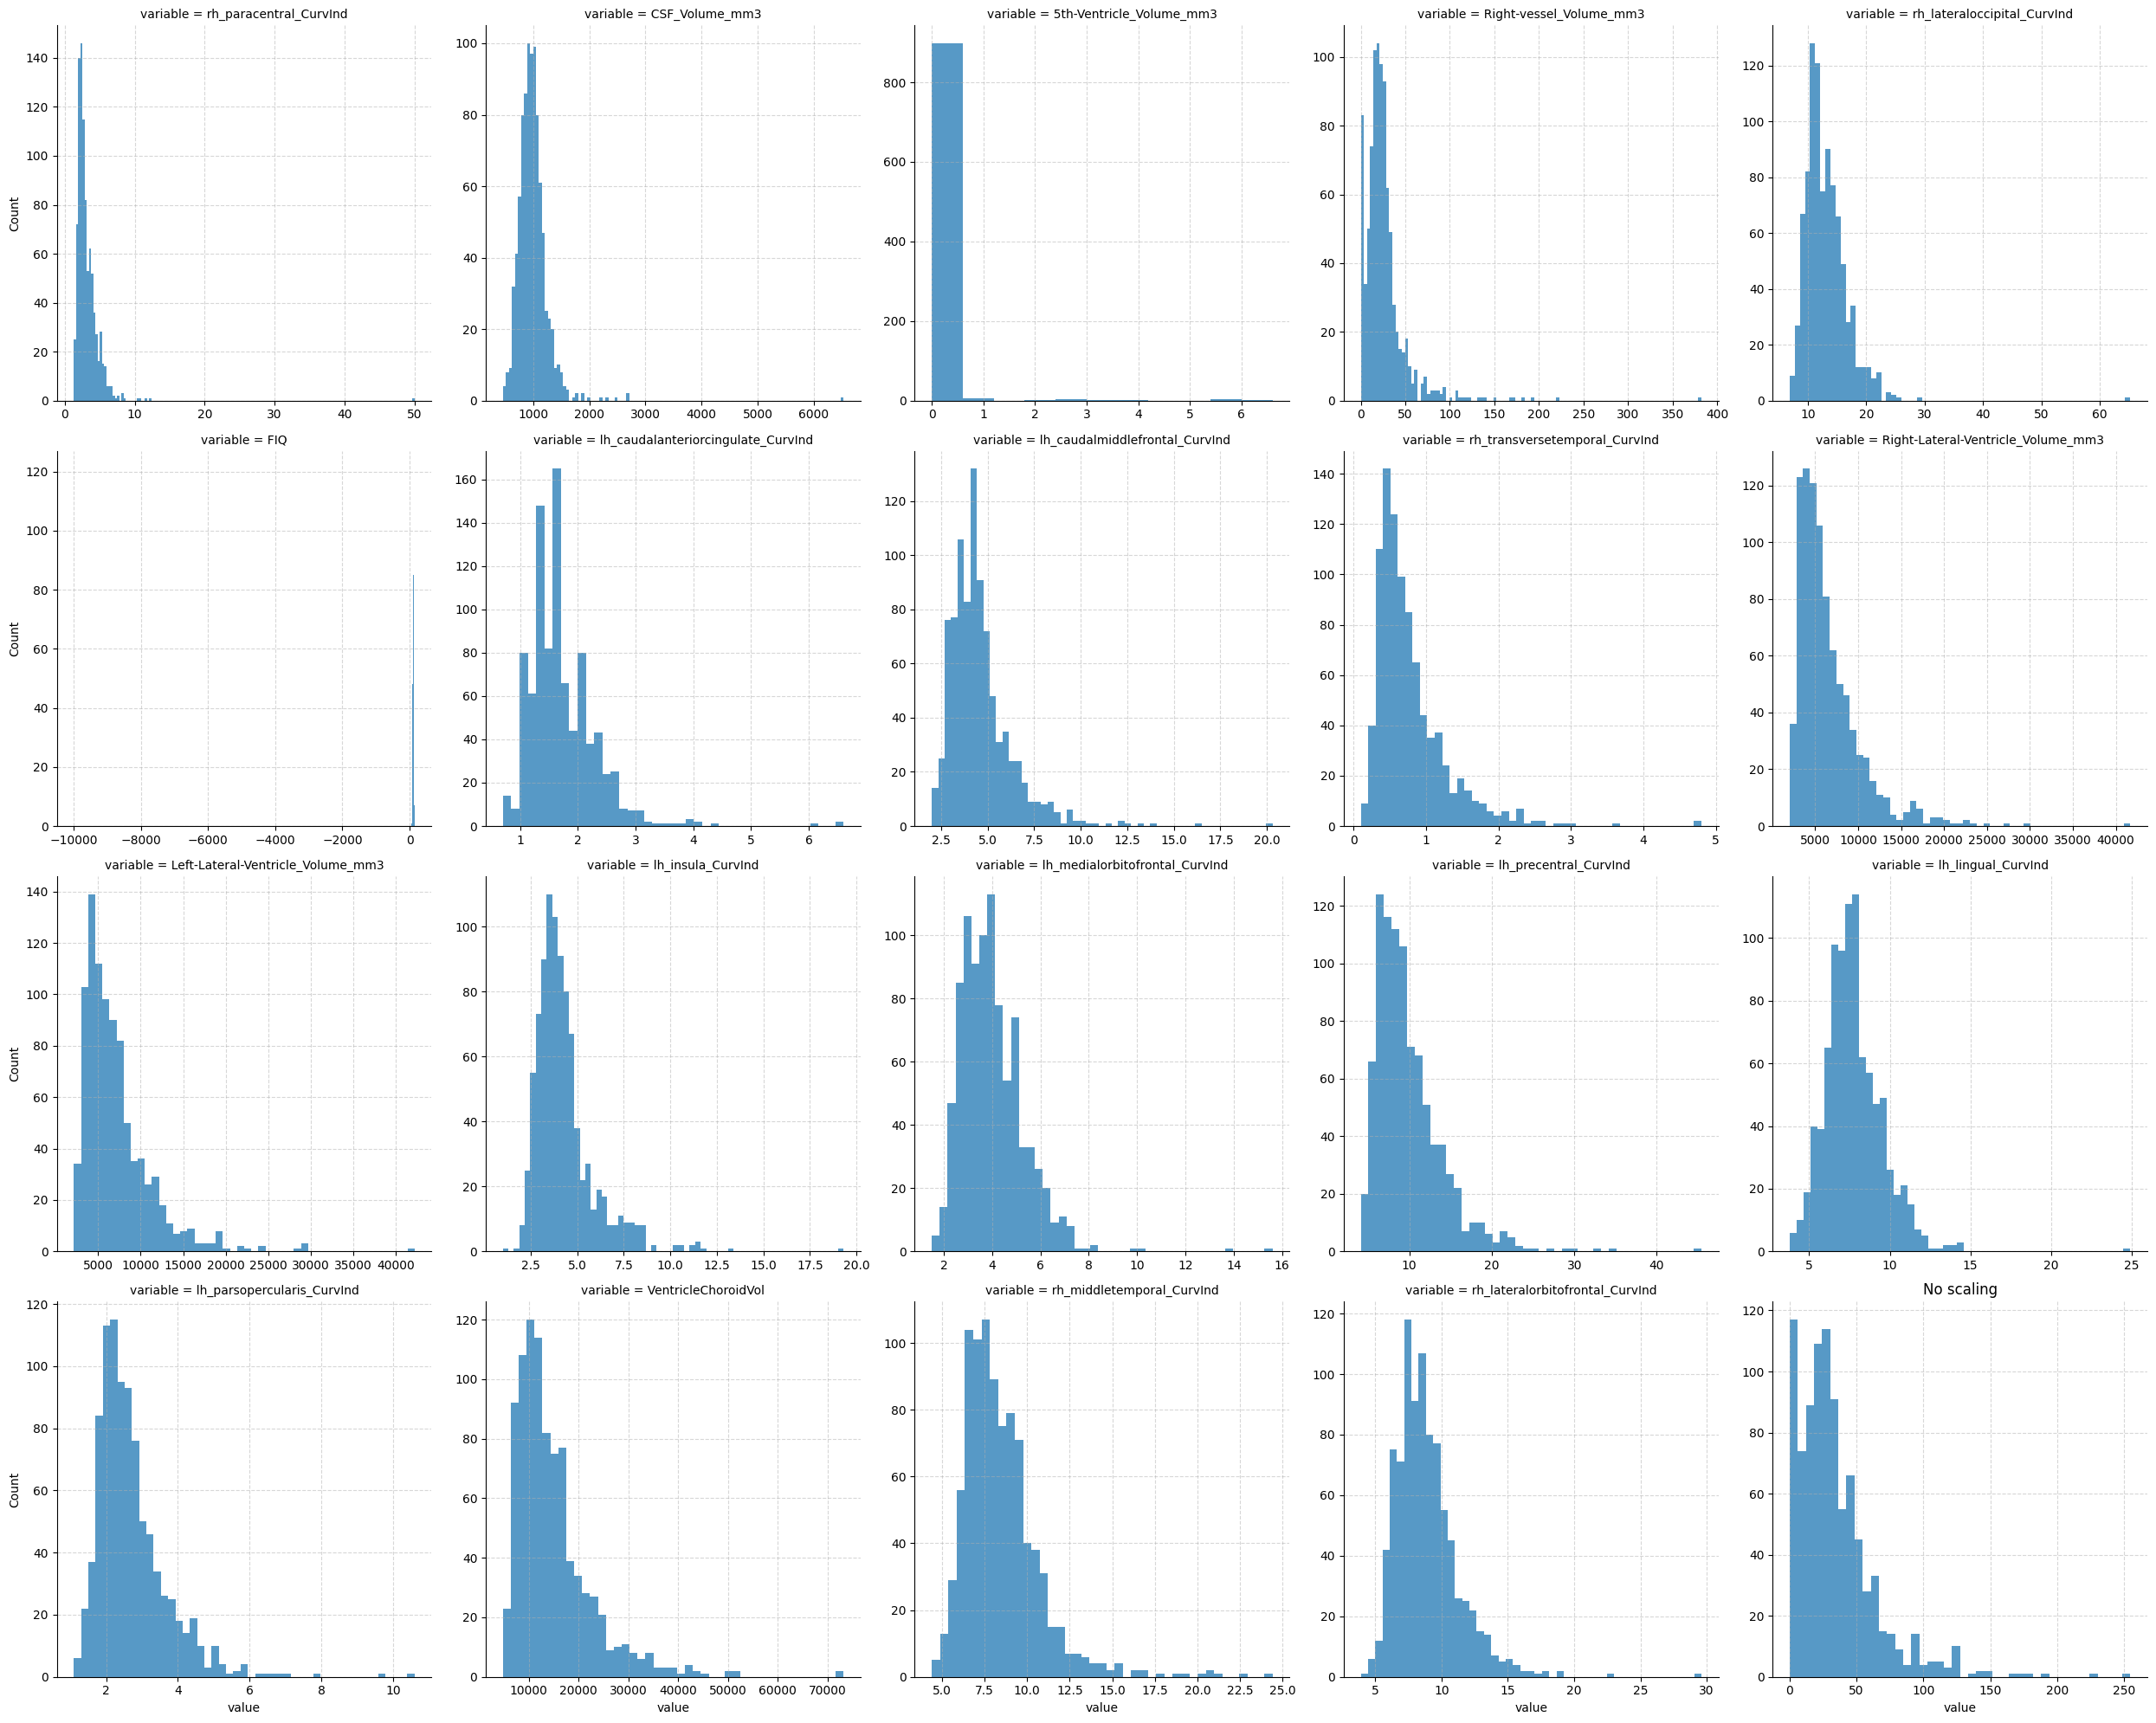

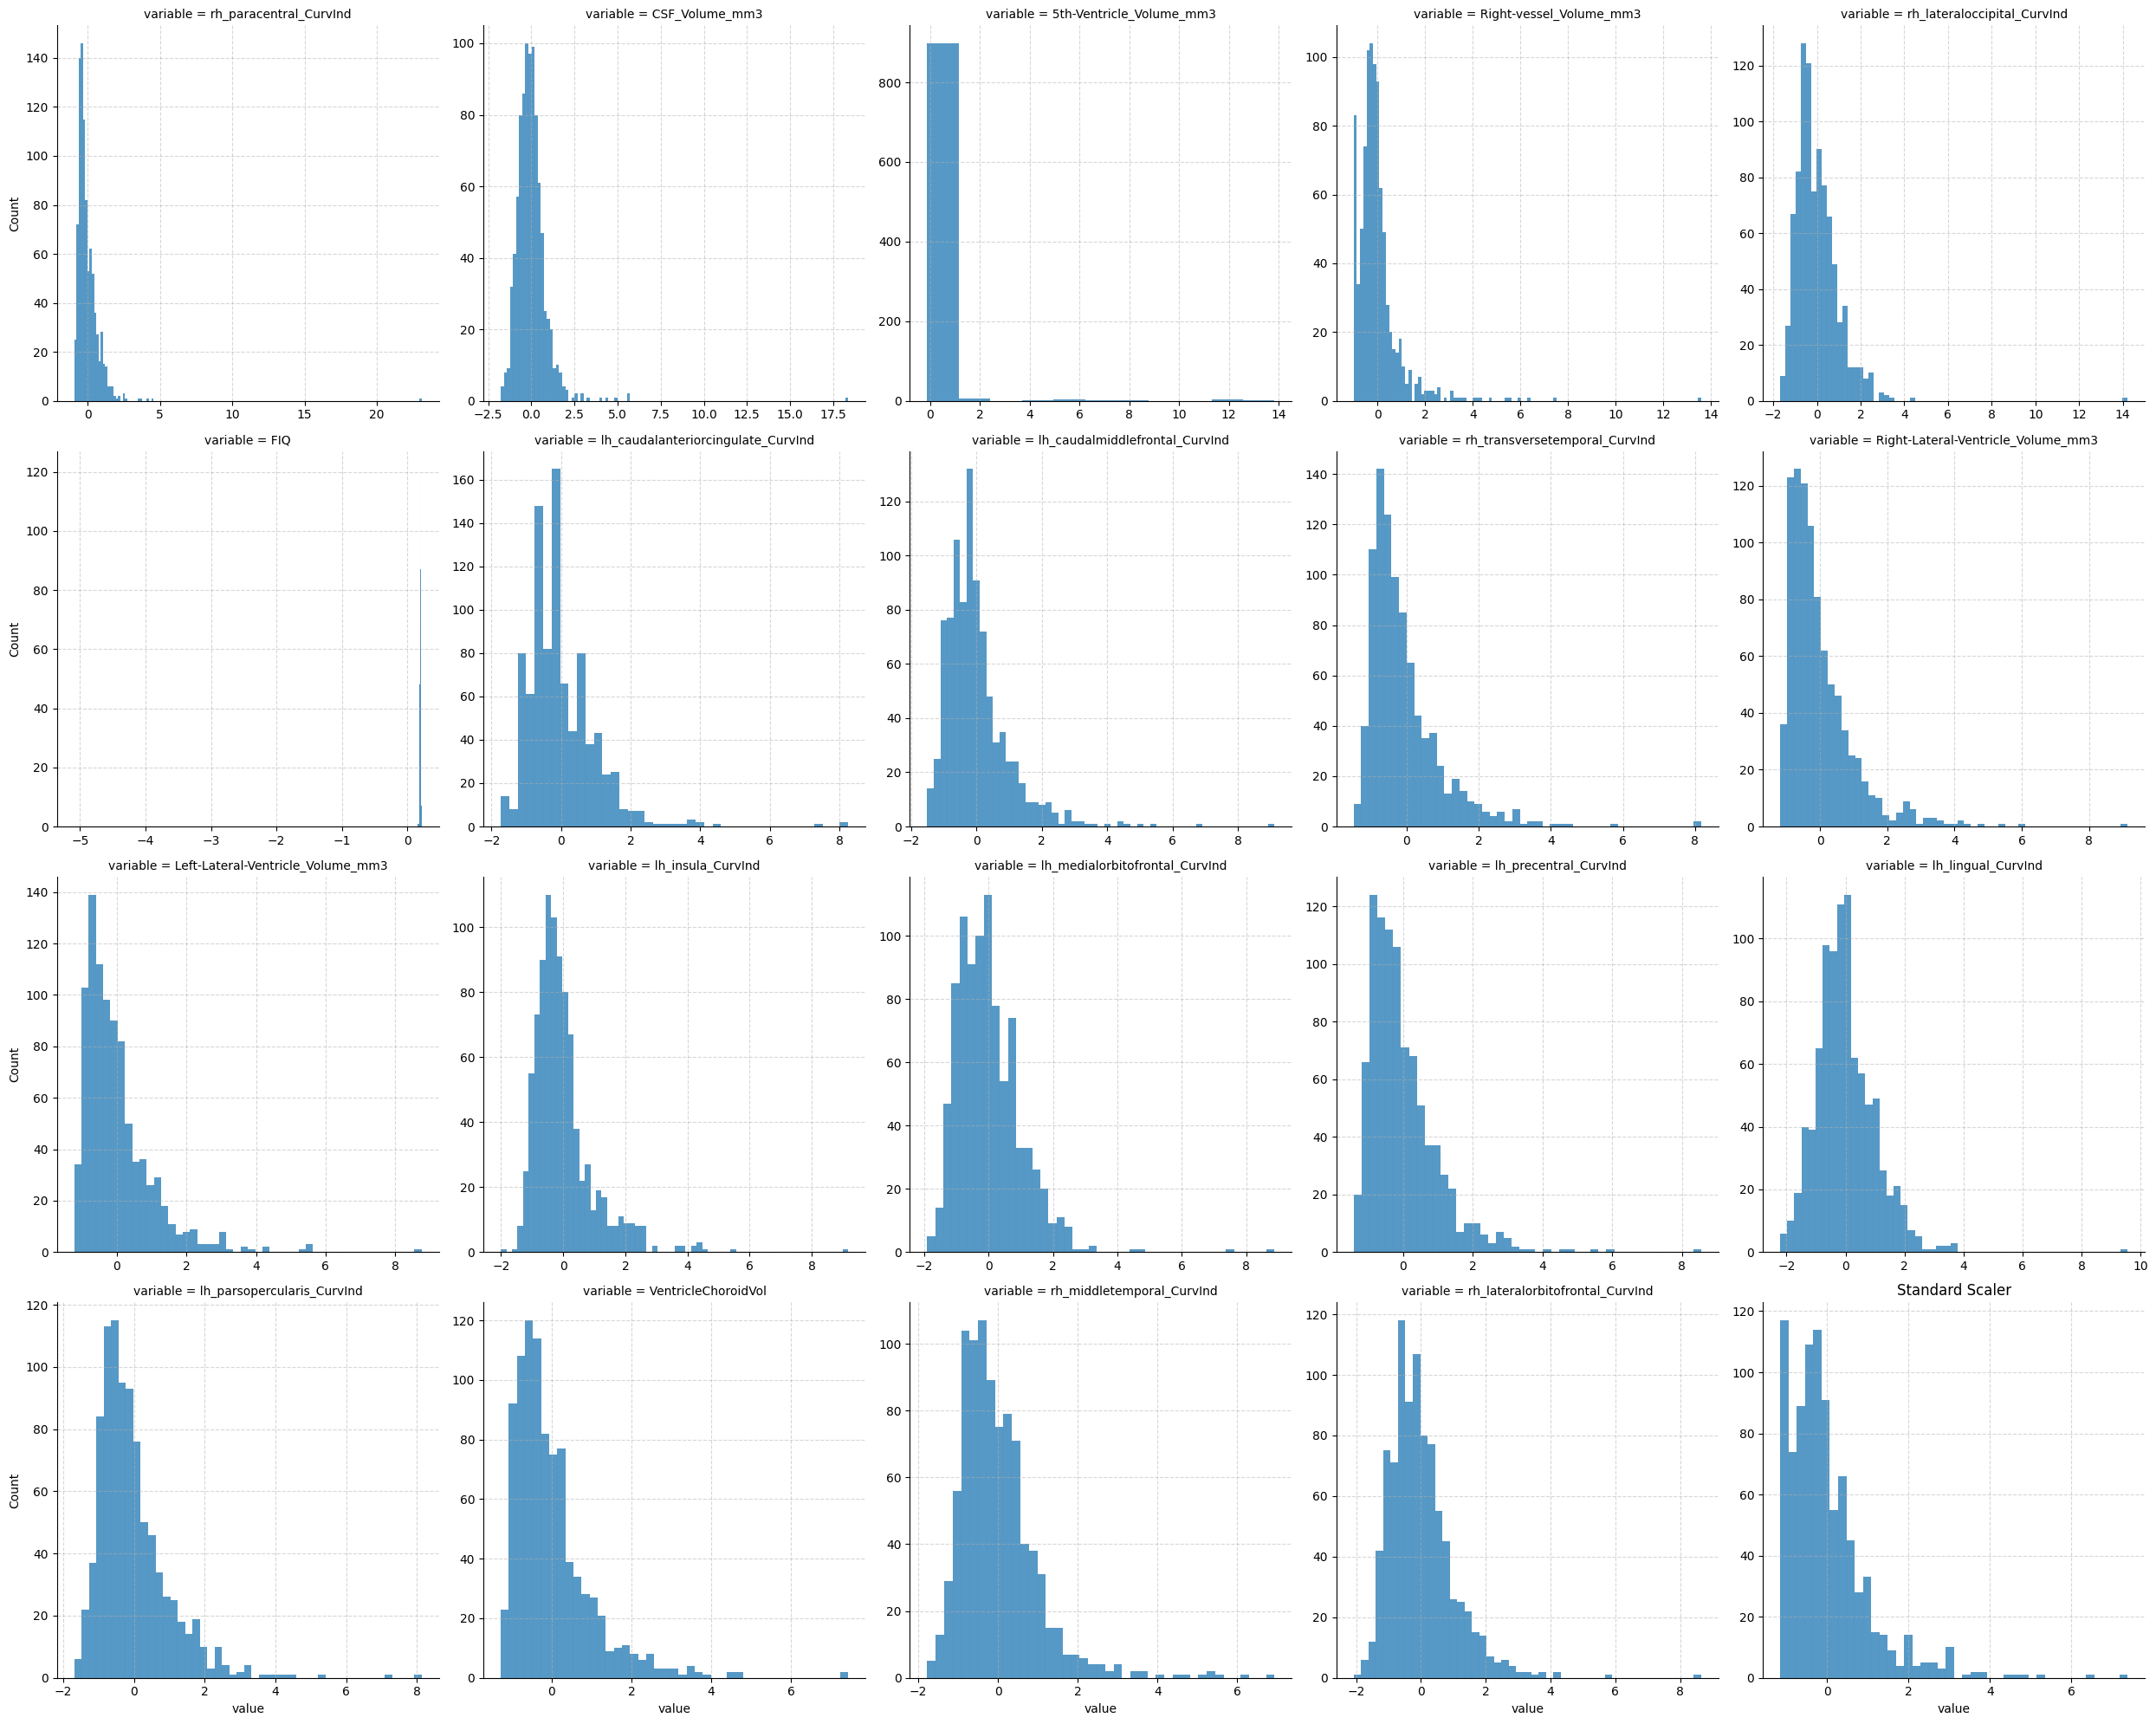

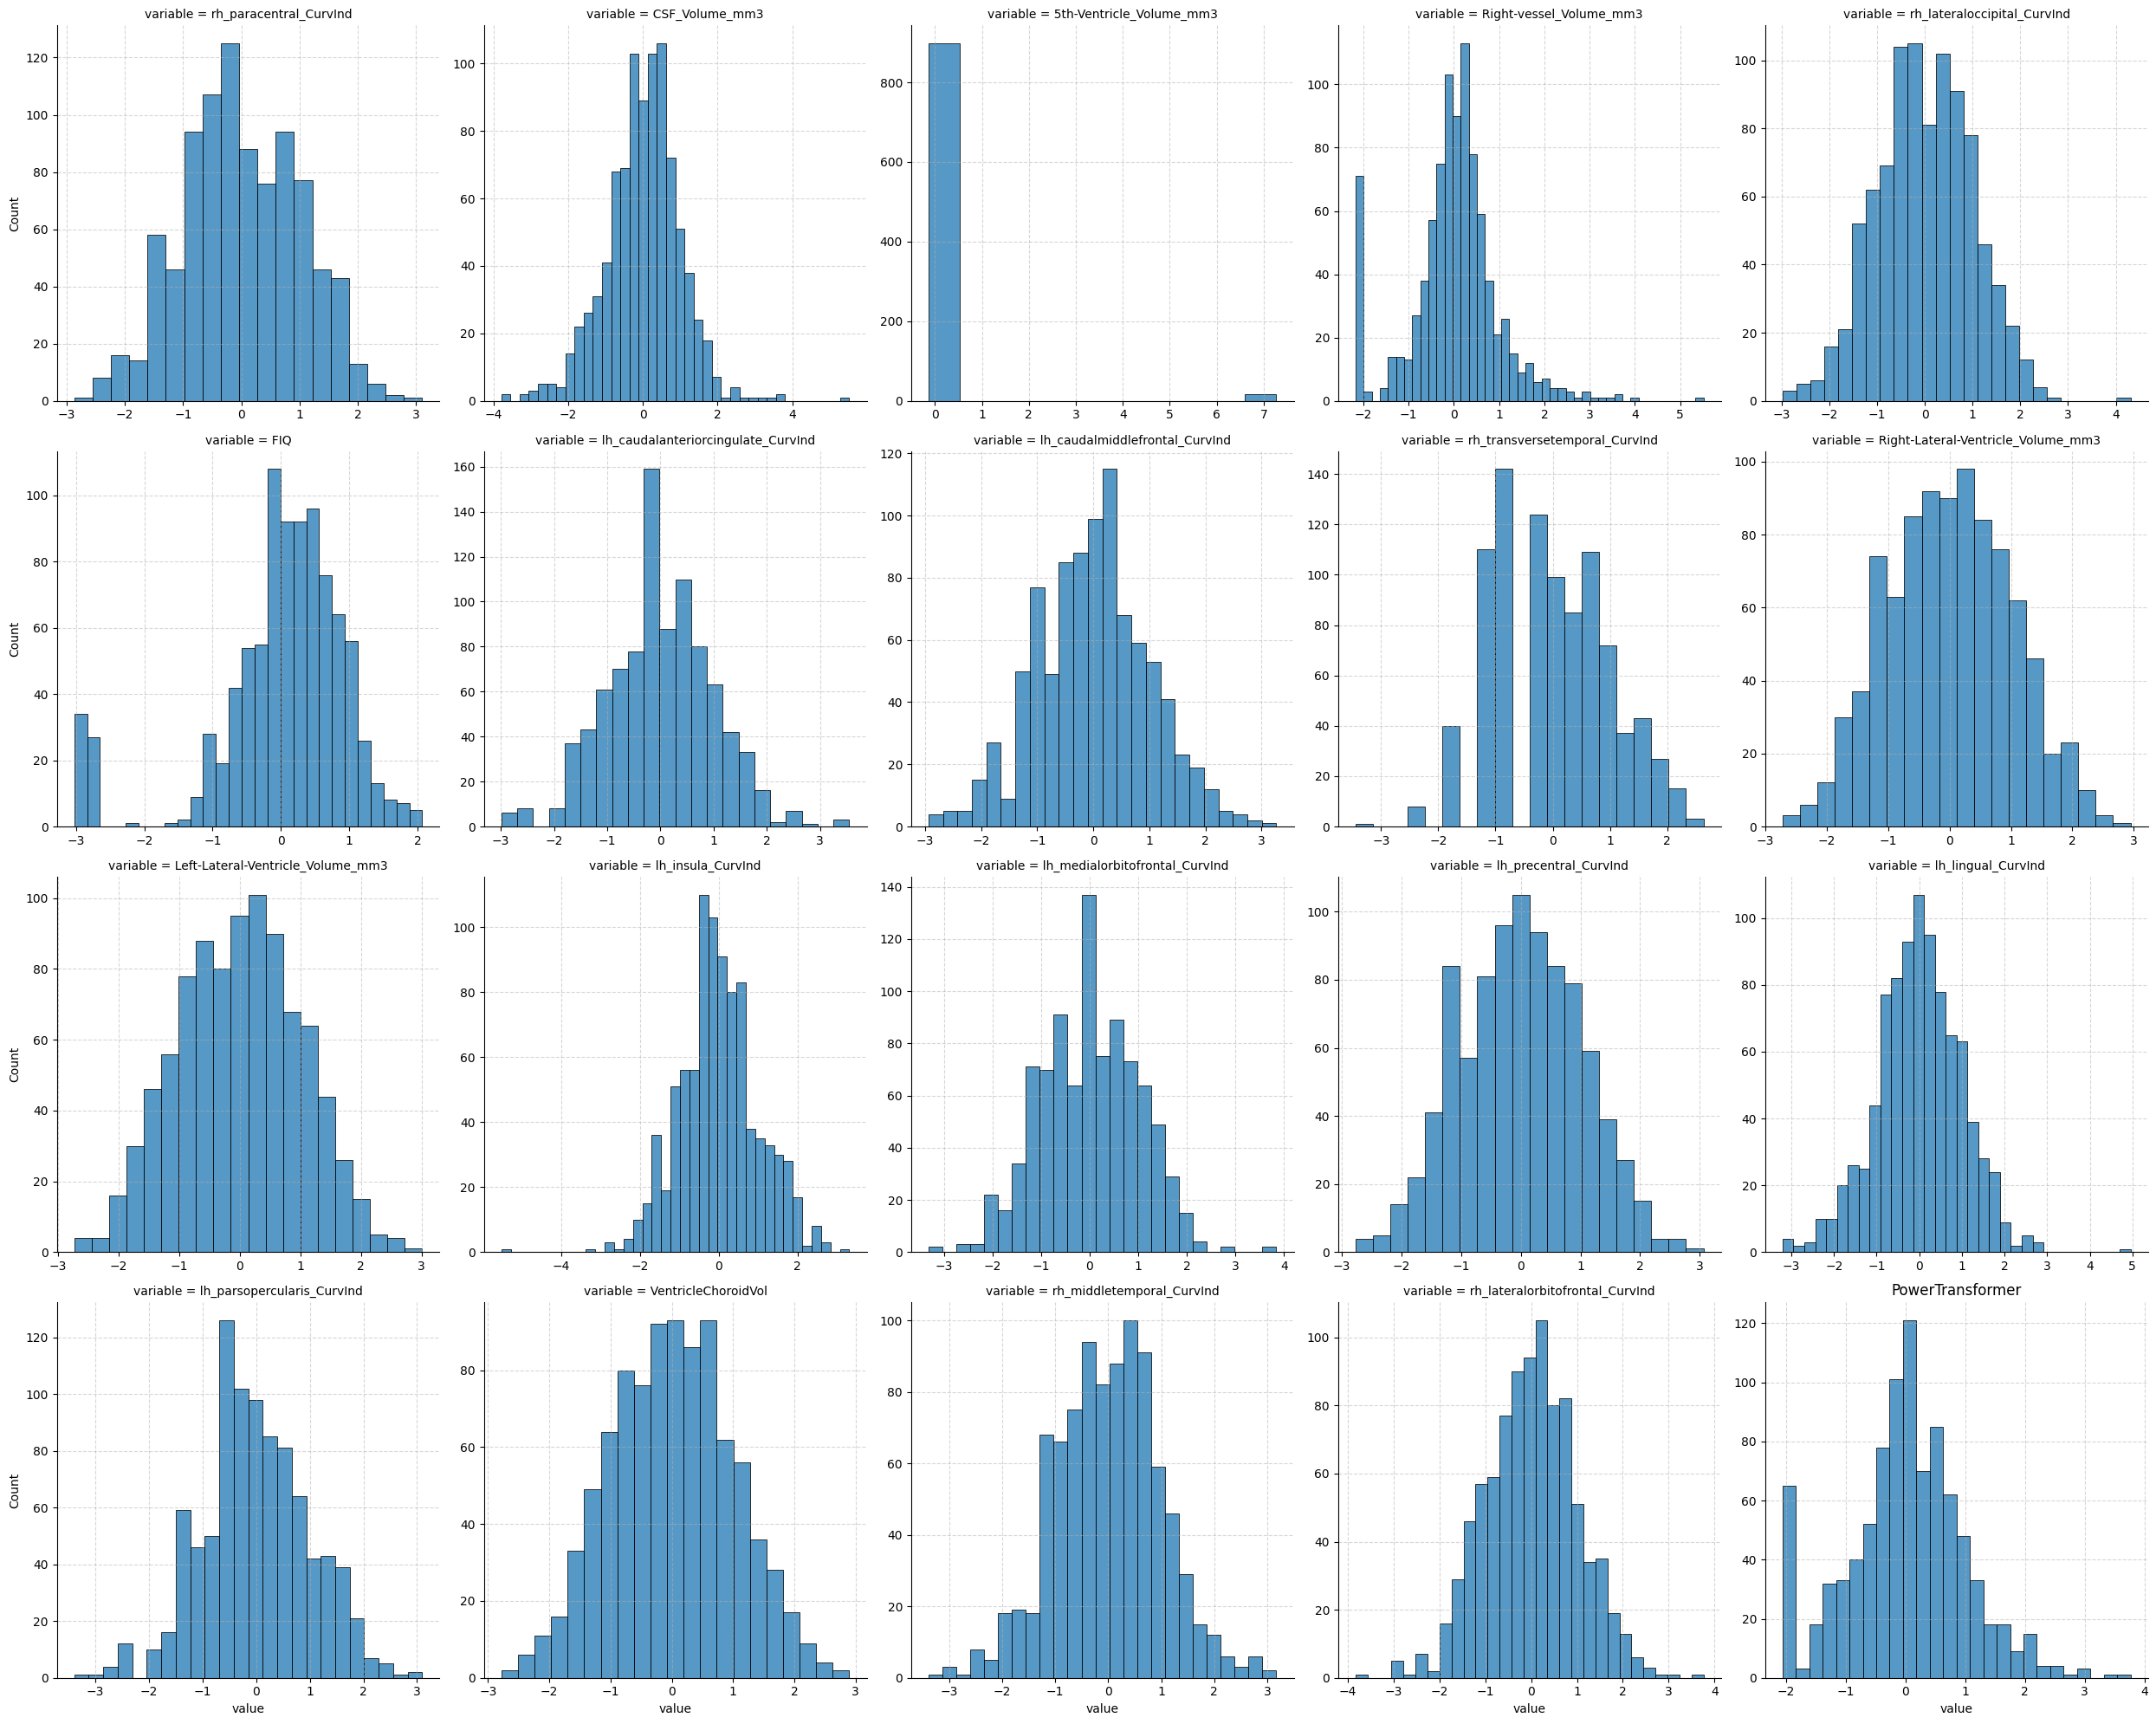

In [231]:
scalers = [same, StandardScaler(), PowerTransformer()]
names = ["No scaling", "Standard Scaler", "PowerTransformer"]

for scaler, name in zip(scalers, names):
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    g = sns.displot(
        data=scaled_df[high_variance_col].melt(),
        x="value",
        col="variable",
        facet_kws={"sharey":False, "sharex":False},
        common_bins=False,
        col_wrap=5
    )
    plt.title(name)
        


## PCA

The first step is to reduce the dimensionality of the input data,  to prevent overfitting and to reduce computational time.

This can be done trough the use of PCA, since it
Not all features are useful to predict the target, because some of them have a

In [221]:
from sklearn.decomposition import PCA

(-20.0, 422.0)

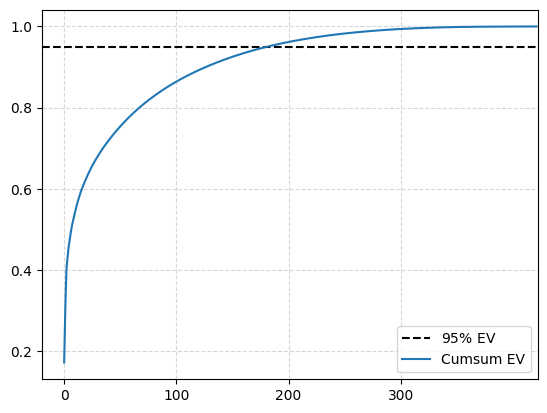

In [235]:
# normalize the data
pca = PCA().fit(scaled_df)

plt.hlines(0.95, -20, df.shape[1], ls="--", color="black", label=r"95$\%$ EV")
plt.plot(pca.explained_variance_ratio_.cumsum(), label="Cumsum EV")
plt.legend(loc="lower right")

plt.xticks(range(0 , 400, 100))
plt.xlim(-20, df.shape[1])

In [278]:
nfeatures_to_keep = np.where(pca.explained_variance_ratio_.cumsum() >= 0.95)[0][0]
df_pca = pca.transform(scaled_df)[:,:nfeatures_to_keep]

## Feature selection

In [279]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor

In [280]:
featsel = SequentialFeatureSelector(
    DecisionTreeRegressor(max_depth=5), 
    n_features_to_select=50, 
    direction='forward',
    scoring="neg_mean_absolute_error"
)

In [281]:
featsel.fit(df_pca, y)

SequentialFeatureSelector(estimator=DecisionTreeRegressor(max_depth=5),
                          n_features_to_select=50,
                          scoring='neg_mean_absolute_error')

In [282]:
featsel.get_support()

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False,  True,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False,  True,  True, False,  True, False, False, False,
       False,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False,  True, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,

In [285]:
df_after_featsel = df_pca[:, featsel.get_support()]

In [292]:
tree = DecisionTreeRegressor(max_depth=5).fit(df_after_featsel, y)

In [294]:
y_pred = tree.predict(df_after_featsel)

In [298]:
from sklearn.metrics import r2_score

r2_score(y_pred, y)

0.6522502261779483